In [48]:
import pandas as pd
import numpy as np
from fastai.vision.all import *

from fastai.vision.core import PILImage, PILMask
from fastai.vision.data import ImageBlock, MaskBlock, imagenet_stats
from PIL import Image

In [49]:
SEED=2021
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    #tf.set_random_seed(seed)
seed_everything(SEED)
torch.backends.cudnn.benchmark = True

In [50]:
path = Path("/data/datasets/severstal")
df = pd.read_csv(path/'train.csv')

In [51]:
#path = Path("/data/datasets/severstal")
Path.BASE_PATH = path

Getting the list of image names with defects:

In [52]:
path.ls()

(#6) [Path('test_images'),Path('train_images'),Path('train.csv'),Path('masks'),Path('codes.txt'),Path('sample_submission.csv')]

In [53]:
defected_list = list(df.ImageId.unique())

Defining a function to get the categories `defect/no defect` as 1 and 0 respectively:

In [54]:
def name_in_list(image_name):
    if image_name in defected_list:
        return 1
    else:
        return 0

Now, it comes the DataBlock definition. The selected method for the first resizing was `squish` as random crop might get relevant sections of the image (i.e. parts with defects on it) out of the frame, compounded by the fact the image ratio size is significant. (_TODO:_ `pad` might be a better option if there's a way to use `pad_mode=reflection` as shown in https://docs.fast.ai/vision.augment#Resize):

In [55]:
images = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 get_y=using_attr(name_in_list, 'name'),
                 item_tfms=Resize(1600, method='squish'),
                 batch_tfms=aug_transforms(size=700, min_scale=0.8)
                  )

images.summary(path/'train_images')

In [56]:
dls = images.dataloaders(path/"train_images", batch_size=32)

Setting now our learner:

In [57]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)

Finding out the proper LR:

SuggestedLRs(lr_min=0.001096478197723627, lr_steep=7.585775847473997e-07)

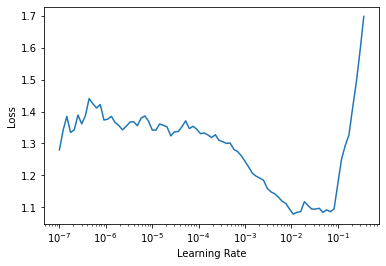

In [58]:
learn.lr_find()

Let's train with the LR found:

In [59]:
learn.fine_tune(12, base_lr=1e-04)

epoch,train_loss,valid_loss,error_rate,time
0,0.761237,0.410652,0.194986,09:34


epoch,train_loss,valid_loss,error_rate,time
0,0.616276,0.356409,0.164345,11:26
1,0.495535,0.310650,0.136490,11:25
2,0.457229,0.252428,0.108237,11:25
3,0.404024,0.224174,0.093116,11:25
4,0.341818,0.234087,0.091126,11:24
5,0.319787,0.196243,0.083565,11:25
6,0.305455,0.185404,0.072423,11:25
7,0.256945,0.179581,0.068046,11:25
8,0.240959,0.178476,0.074413,11:25
9,0.248797,0.165158,0.062475,11:24


Plotting the loss:

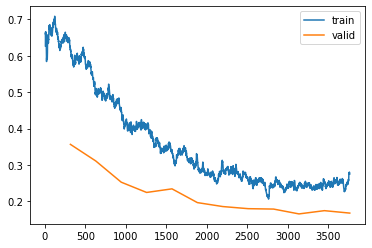

In [60]:
learn.recorder.plot_loss()

In [64]:
learn.export(fname='bin_class_finalv3.pkl')

In [67]:
learn.save('bin_class_v3')

Path('models/bin_class_v4.pth')

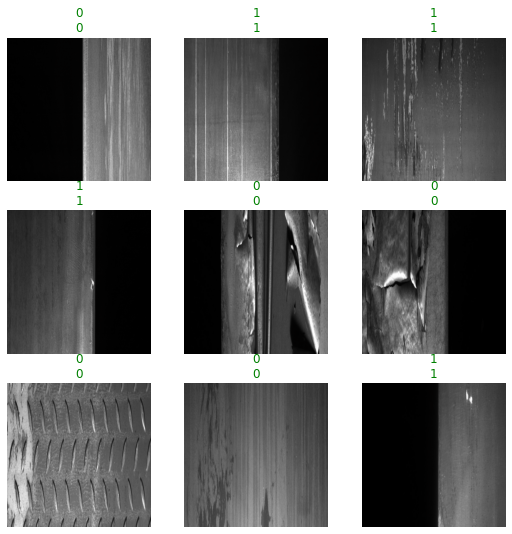

In [63]:
learn.show_results()